In [1]:
import glob
import os
import scipy
import torch
import numpy as np
import flow_transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.nn.functional import grid_sample
from imageio import imread

def load_flo(path):
    with open(path, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        assert(202021.25 == magic),'Magic number incorrect. Invalid .flo file'
        h = np.fromfile(f, np.int32, count=1)[0]
        w = np.fromfile(f, np.int32, count=1)[0]
        data = np.fromfile(f, np.float32, count=2*w*h)
    # Reshape data into 3D array (columns, rows, bands)
    data2D = np.resize(data, (w, h, 2))
    return data2D

def default_loader(root, path_imgs, path_flo, path_occ):
    imgs = [os.path.join(root,path) for path in path_imgs]
    flo = os.path.join(root,path_flo)
    occ = os.path.join(root,path_occ)
    return [imread(img).astype(np.float32) for img in imgs], load_flo(flo), imread(occ)

In [2]:
images = []
scene_dir = 'alley_1'
for flow_map in sorted(glob.glob(os.path.join('sintel','flow',scene_dir,'*.flo'))):
    flow_map = os.path.relpath(flow_map, os.path.join('sintel','flow'))
    
    scene_dir, filename = os.path.split(flow_map)
    no_ext_filename = os.path.splitext(filename)[0]
    prefix, frame_nb = no_ext_filename.split('_')
    frame_nb = int(frame_nb)
    
    img1 = os.path.join('clean', scene_dir, '{}_{:04d}.png'.format(prefix, frame_nb))
    img2 = os.path.join('clean', scene_dir, '{}_{:04d}.png'.format(prefix, frame_nb+1))
    occ_mask = os.path.join('occlusions', scene_dir, '{}_{:04d}.png'.format(prefix, frame_nb))
    flow_map = os.path.join('flow', flow_map)
    
    if not (os.path.isfile(os.path.join('sintel',img1)) and os.path.isfile(os.path.join('sintel',img2))):
        continue
    images.append([[img1,img2], flow_map, occ_mask])

split_factor = 1.1     ## ratio of train split
split_values = np.random.uniform(0,1,len(images)) < split_factor
train_samples = [sample for sample, split in zip(images, split_values) if split]
test_samples = [sample for sample, split in zip(images, split_values) if not split]

#print(train_samples[0], test_samples[0])

In [3]:
root = 'sintel'
#index = 8

#inputs, target, mask = train_samples[index] # or test_samples (path_list)
#print(mask)

#import matplotlib.image as mpimg
#img1 = mpimg.imread(os.path.join(root, inputs[0]))
#img2 = mpimg.imread(os.path.join(root, inputs[1]))
#mask = mpimg.imread(os.path.join(root, mask))
#mask = np.repeat(np.expand_dims(mask, axis=2), 3, axis=2)
#print(img1.max())

#fig = plt.figure()
#a = fig.add_subplot(3, 1, 1)
#imgplot = plt.imshow(img1)
#a = fig.add_subplot(3, 1, 2)
#imgplot = plt.imshow(img2)
#a = fig.add_subplot(3, 1, 3)
#imgplot = plt.imshow(mask)



In [4]:
## Sampled frames
start_frame = 5
end_frame = 40

inputs, target, mask = train_samples[start_frame]
inputs, target, mask = default_loader(root, inputs, target, mask)
target = torch.from_numpy(target)

width = target.size(1)
height = target.size(0)

## Grid Location Point (x,y) matrix of size H X W
X = torch.Tensor([[range(height)]*width]).transpose(1,2)
Y = torch.Tensor([[range(width)]*height])
Grid = torch.cat([X,Y], 0).permute(1, 2, 0)

offset = torch.zeros(height, width, 2)     ## sum of flows from start to end frame.  H x W x 2
source_grid = torch.ones(height, width)    ## Survived points in start frame image.  H x W

new_Grid = Grid.clone()
new_Grid_norm = torch.zeros(Grid.size()).unsqueeze(0)
for ind in range(start_frame, end_frame):
    imgs, target, mask = train_samples[ind]
    target = torch.from_numpy(load_flo(os.path.join(root, target)))                  ## Flow annotation. H x W x 2
    mask = torch.from_numpy(imread(os.path.join(root, mask))).float() / 255          ## Occlusion mask. H x W
    
    if ind == start_frame:
        new_mask = mask
    else:
        ## Warping Occlusion Mask
        new_mask = grid_sample(mask[(None,)*2 + (...,)], 
                               new_Grid_norm, mode='nearest', 
                               align_corners=True)[0][0]
    source_grid = source_grid * (1 - new_mask)
    
    new_Grid[:,:,0] = torch.clamp((new_Grid[:,:,0] + target[:,:,0]), 0, height-1)
    new_Grid[:,:,1] = torch.clamp((new_Grid[:,:,1] + target[:,:,1]), 0, width-1)
    
    new_Grid_norm[:,:,:,1] = 2.0*new_Grid[:,:,0].clone() / max(height-1,1)-1.0       
    new_Grid_norm[:,:,:,0] = 2.0*new_Grid[:,:,1].clone() / max(width-1,1)-1.0
    
    
print(source_grid.sum())
outputs, target, mask = train_samples[end_frame]    
outputs, _, mask = default_loader(root, outputs, target, mask)

source_points = (source_grid == 1).nonzero().transpose(0,1)
target_points = new_Grid[source_points[0], source_points[1]].long().transpose(0,1)
print(source_points.size())

tensor(296618.)
torch.Size([2, 296618])


In [5]:
#########################################################
#################   Visualize Matches   #################
#########################################################

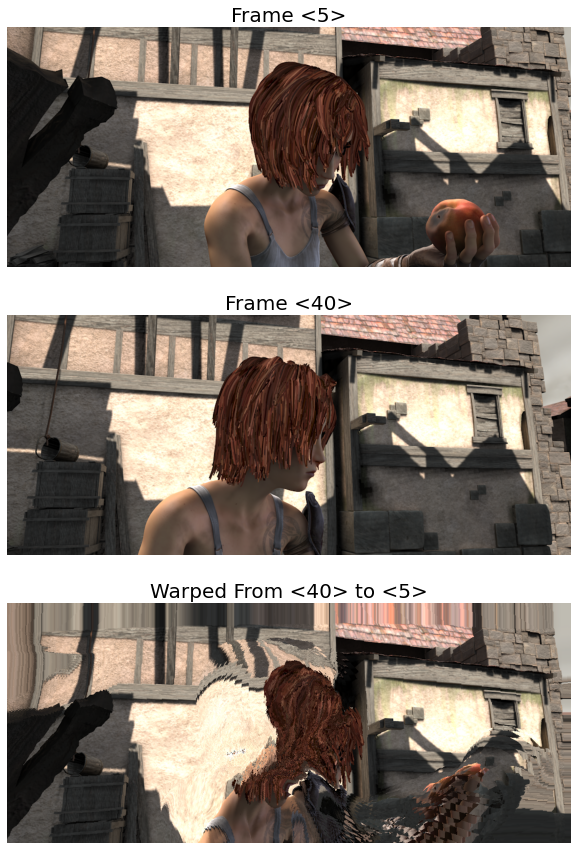

In [6]:
## Warping Flow & Visualize
src = inputs[0]
tar = outputs[0]
src = torch.from_numpy(src).permute(2,0,1).unsqueeze(0)
warped_img = grid_sample(src, new_Grid_norm, mode='nearest', align_corners=True)
#warped_img = warped_img * source_grid + 255 * (1 - source_grid)
#src = src * source_grid + 255 * (1 - source_grid)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3,1,1)
ax1.set_title('Frame <%d>'% start_frame, fontsize=20)
ax1.axis("off")
ax1.imshow(src[0].permute(1,2,0).numpy()/255)
ax2 = fig.add_subplot(3,1,2)
ax2.set_title('Frame <%d>'% end_frame, fontsize=20)
ax2.axis("off")
ax2.imshow(tar/255)
ax3 = fig.add_subplot(3,1,3)
ax3.set_title('Warped From <%d> to <%d>'% (end_frame, start_frame), fontsize=20)
ax3.axis("off")
ax3.imshow(warped_img[0].permute(1,2,0).numpy()/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


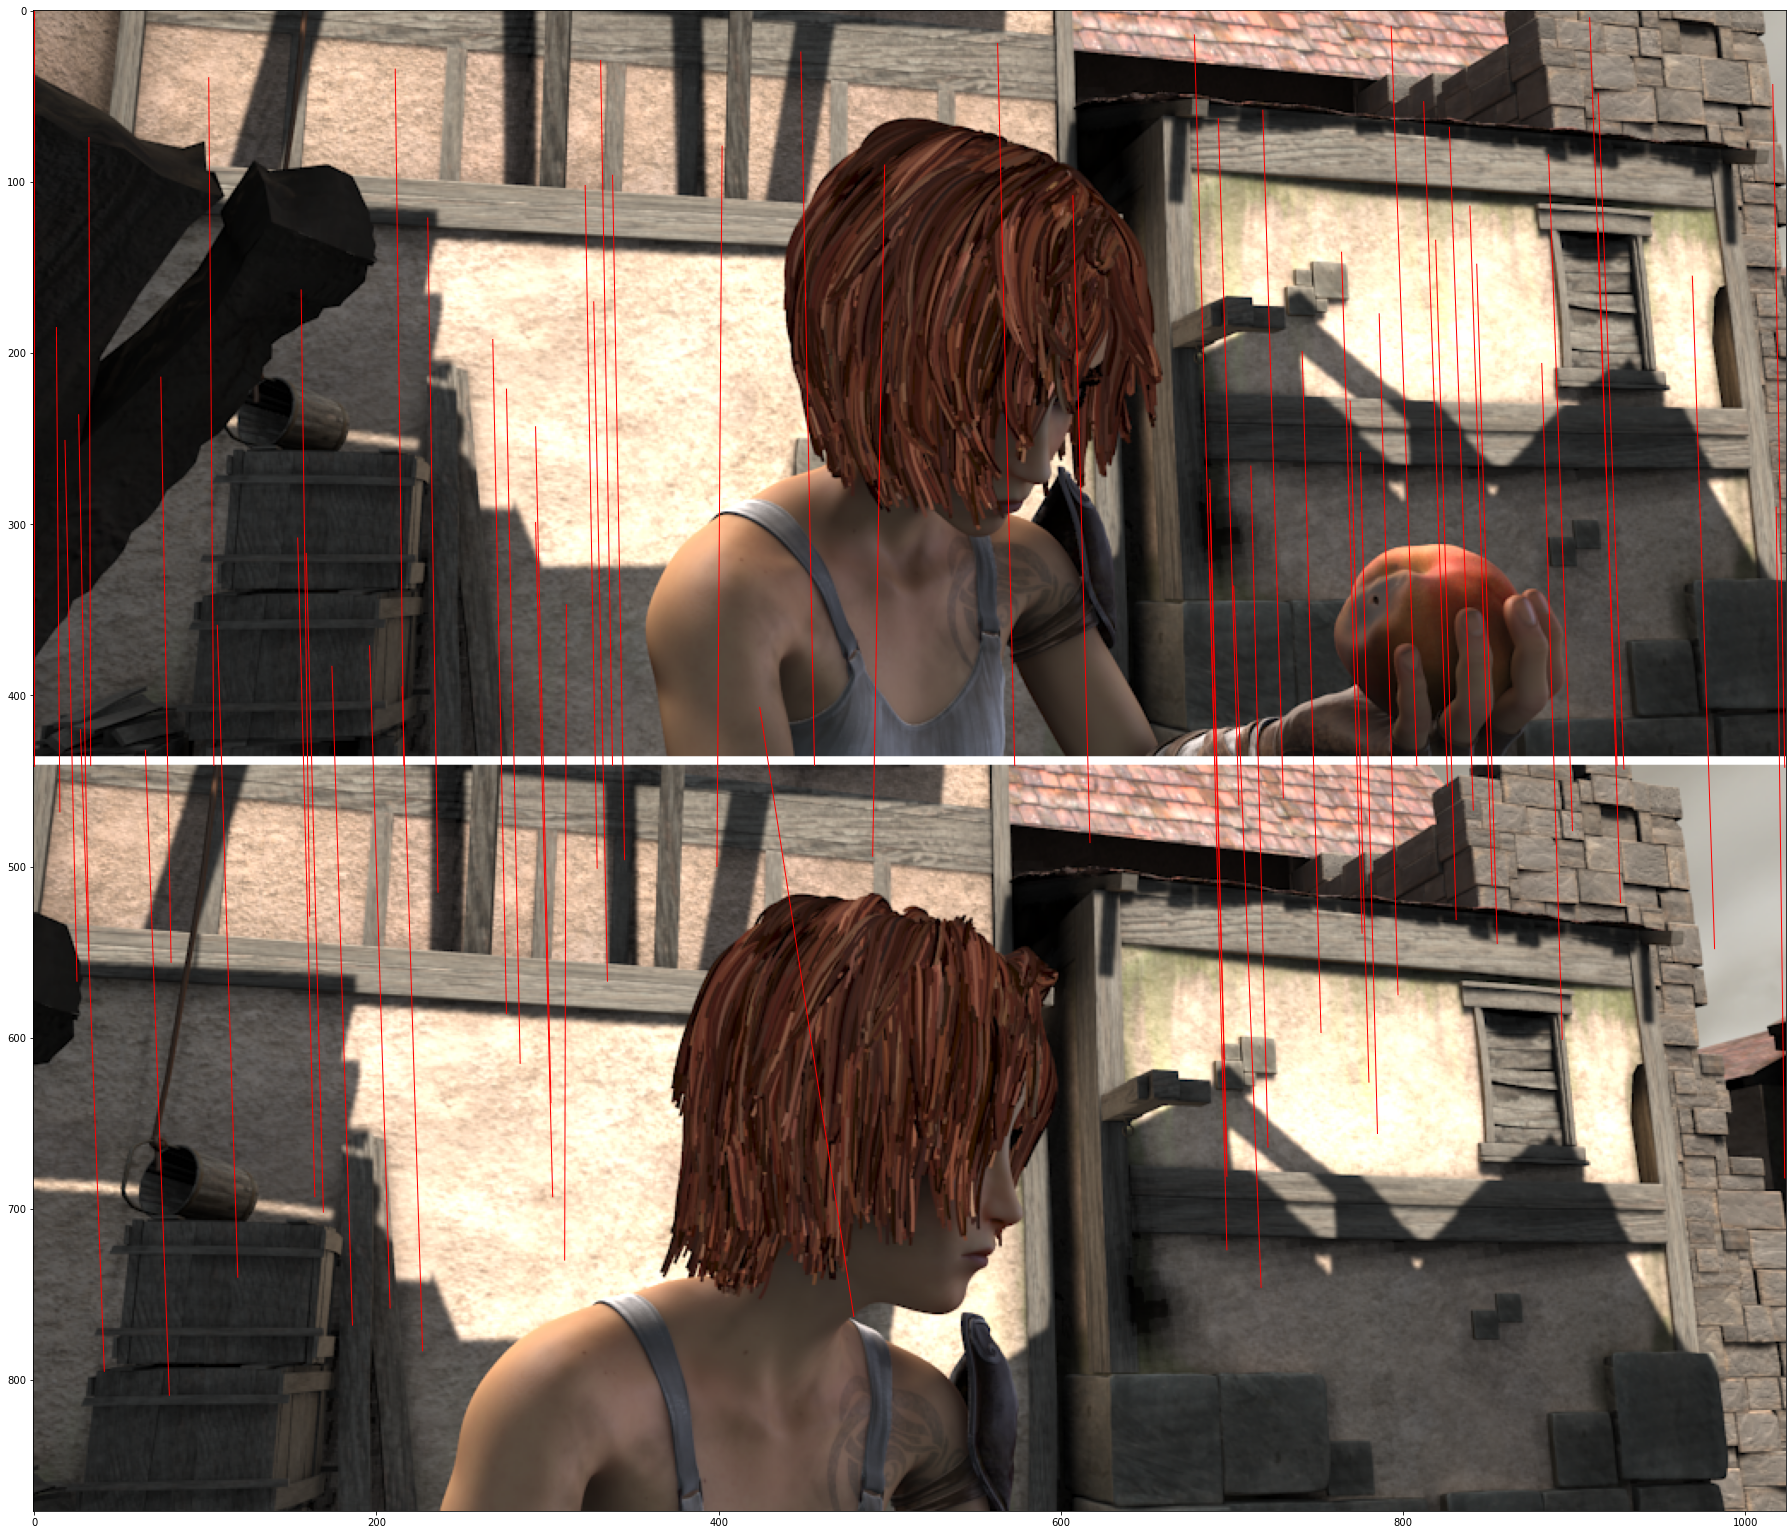

In [8]:
from utils import build_composite_image

img1 = os.path.join(root, train_samples[start_frame][0][0])
img2 = os.path.join(root, train_samples[end_frame][0][0])

im, v_offset, h_offset = build_composite_image(img1, img2, margin=5, axis=0)

plt.figure(figsize=(25,25))
plt.imshow(im)

_, target, mask = train_samples[start_frame]
target = torch.from_numpy(load_flo(os.path.join(root, target)))

linewidth = 1
for idx in range(0, int(source_points.size(1)), 5000):
    #print(source_points[:,idx], target_points[:,idx], target[source_points[0,idx],source_points[1,idx],:])
    plt.plot((source_points[1,idx] + h_offset[0], target_points[1,idx] + h_offset[1]),
             (source_points[0,idx] + v_offset[0], target_points[0,idx] + v_offset[1]),
             color='r',
             linewidth=linewidth)

        
plt.tight_layout()
#plt.axis('off')

In [ ]:
#########################################################
################   Image Preprocessing   ################
#########################################################

In [ ]:
####### Data Pre-processing #######

input_transform = transforms.Compose([
    flow_transforms.ArrayToTensor(),
    transforms.Normalize(mean=[0,0,0], std=[255,255,255]),
    transforms.Normalize(mean=[0.45,0.432,0.411], std=[1,1,1])
])
target_transform = transforms.Compose([
    flow_transforms.ArrayToTensor(),
    transforms.Normalize(mean=[0,0],std=[20,20])
])
## sparse ##
co_transform = flow_transforms.Compose([
    flow_transforms.RandomCrop((320,448)),
    flow_transforms.RandomVerticalFlip(),
    flow_transforms.RandomHorizontalFlip()
])

print(inputs[0].shape, target.shape)   ### Compare before & after data pre-processing ###
if co_transform is not None:
    inputs, target = co_transform(inputs, target)
if input_transform is not None:
    inputs[0] = input_transform(inputs[0])
    inputs[1] = input_transform(inputs[1])
if target_transform is not None:
    target = target_transform(target)

print(inputs[0][0,100:107,100:107])
print(target[0].max(), target[1].max())
print(inputs[0].size(), target.size())